# cosmocnc tutorial

In this tutorial we will illustrate the main computational capabilities of cosmocnc using a Simons-Observatory-like cluster catalogue with two mass observables, the tSZ signal-to-noise and the CMB lensing signal-to-noise.

## Input parameters

We first set the cosmocnc input parameters.

In [1]:
import numpy as np
import pylab as pl
import cosmocnc

cnc_params = cosmocnc.cnc_params_default
scal_rel_params = cosmocnc.scaling_relation_params_default
cosmo_params = cosmocnc.cosmo_params_default

#Catalogue and observables

cnc_params["cluster_catalogue"] = "SO_sim_0"
cnc_params["observables"] = [["q_so_sim"],["p_so_sim"]]
cnc_params["obs_select"] = "q_so_sim"

#Mass and redshift range

cnc_params["M_min"] = 1e13
cnc_params["M_max"] = 1e16
cnc_params["z_min"] = 0.01
cnc_params["z_max"] = 3.

#Selection observable range

cnc_params["obs_select_min"] = 5. #selection threshold
cnc_params["obs_select_max"] = 200.

#Precision parameters

cnc_params["n_points"] = 16384 #number of points in which the mass function at each redshift (and all the convolutions) is evaluated
cnc_params["n_points_data_lik"] = 2048 #number of points in which the mass function at each redshift (and all the convolutions) is evaluated
cnc_params["n_z"] = 100
cnc_params["sigma_mass_prior"] = 10
cnc_params["delta_m_with_ref"] = True
cnc_params["scalrel_type_deriv"] = "numerical"
cnc_params["downsample_hmf_bc"] = 2
cnc_params["compute_abundance_matrix"] = True

#Parallelisation

cnc_params["number_cores_hmf"] = 1
cnc_params["number_cores_abundance"] = 1
cnc_params["number_cores_data"] = 8
cnc_params["parallelise_type"] = "redshift"

#Cosmology parameters

cnc_params["cosmology_tool"] = "classy_sz"
cnc_params["cosmo_param_density"] = "critical"
cnc_params["cosmo_model"] = "lcdm"

#Parameters for the binned likelihood

cnc_params["binned_lik_type"] = "z_and_obs_select"
cnc_params["bins_edges_z"] = np.linspace(cnc_params["z_min"],cnc_params["z_max"],9)
cnc_params["bins_edges_obs_select"] = np.exp(np.linspace(np.log(cnc_params["obs_select_min"]),np.log(cnc_params["obs_select_max"]),7))

#Stacked data, set to False for now

cnc_params["stacked_likelihood"] = False
cnc_params["stacked_data"] = ["p_so_sim_stacked"] #list of stacked data
cnc_params["compute_stacked_cov"] = True


cnc_params["data_lik_from_abundance"] = False
cnc_params["likelihood_type"] = "unbinned"

scal_rel_params["corr_lnq_lnp"] = 0.
scal_rel_params["bias_sz"] = 0.8

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Code initialisation

We now initialise cosmocnc.

In [2]:
number_counts = cosmocnc.cluster_number_counts()

number_counts.cnc_params = cnc_params
number_counts.scal_rel_params = scal_rel_params
number_counts.cosmo_params = cosmo_params

number_counts.initialise()


## Cluster abundance

Let us now compute and plot the cluster abundance across the selection observable (SZ signal-to-noise, or SNR) and redshift.

In [3]:
number_counts.get_number_counts()

dn_dz = number_counts.n_z
dn_dSNR = number_counts.n_obs

z = number_counts.redshift_vec
SNR = number_counts.obs_select_vec


Total clusters 15631.676214198133


As simple as that! We can now plot the one-dimensional abundance across signal-to-noise and redshift.

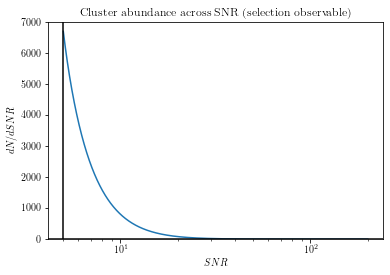

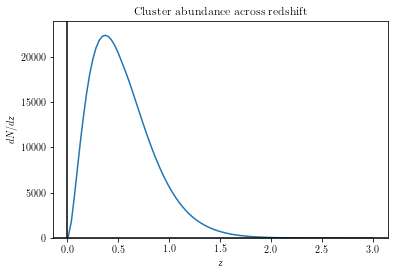

In [4]:
pl.rc('text', usetex=True)
pl.rc('font', family='serif')

pl.semilogx(SNR,dn_dSNR,color="tab:blue")
pl.xlabel("$SNR$")
pl.ylabel("$dN / d SNR$")
pl.axvline(x=5.,color="k")
pl.axhline(y=0.,color="k")
pl.title("Cluster abundance across SNR (selection observable)")
pl.ylim([0,7000])
pl.show()

pl.plot(z,dn_dz,color="tab:blue")
pl.xlabel("$z$")
pl.ylabel("$dN / dz$")
pl.axvline(x=0.,color="k")
pl.axhline(y=0.,color="k")
pl.ylim(0,24000)
pl.title("Cluster abundance across redshift")
pl.show()


We can also retrieve and plot the two-dimensional abundance across both signal-to-noise and redshift.

In [5]:
abundance_matrix = np.flip(number_counts.abundance_matrix,axis=0)

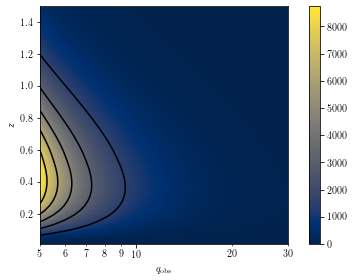

In [6]:
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import StrMethodFormatter

fig = pl.figure()
ax = fig.add_subplot()

im = ax.imshow(abundance_matrix,extent=[SNR[0],SNR[-1],z[0],z[-1]],cmap="cividis",aspect=0.5)
fig.colorbar(im,ax=ax)
ax.contour(np.flip(abundance_matrix,axis=0),colors=["k","k","k","k"],extent=[SNR[0],SNR[-1],z[0],z[-1]])
ax.set_xscale("log")
ax.set_xlabel("$q_{\mathrm{obs}}$")
ax.set_ylabel("$z$")
ax.set_xlim([5.,30.])
ax.set_ylim([0.01,1.5])
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
fig.tight_layout()
pl.show()


We can also retrieve the total number of clusters and compare it to the actual value in the catalogue:

In [7]:
n_tot_theory = number_counts.n_tot
n_tot_obs = number_counts.catalogue.n_tot

print("Predicted total number of clusters in the catalogue:",n_tot_theory,"+-",np.sqrt(n_tot_theory))
print("Observed total number of clusters in the catalogue:",n_tot_obs)

Predicted total number of clusters in the catalogue: 15631.676214198133 +- 125.02670200480429
Observed total number of clusters in the catalogue: 15683


Here, the quoted error on the theoretical prediction is the associated Poisson error.

## Binned cluster abundance

Let us now integrate the cluster abundance within SNR and redshift bins to obtain the binned abundance, and compare it with the cluster catalogue. For this we need to call the binned likelihood. Note that the bin edges were already defined when we set the parameters.

In [8]:
cnc_params["likelihood_type"] = "binned"
cnc_params["obs_select_min"] = 5.000

number_counts.cnc_params = cnc_params

log_lik = number_counts.get_log_lik() #Evaluate the binned likelihood

bins_centres_z = number_counts.bins_centres_z #z bins centres
bins_centres_snr = number_counts.bins_centres_obs #SNR bins centres

n_binned_theory = number_counts.n_binned #Theoretical prediction for the number counts in the SNR-z bins
n_binned_obs = number_counts.n_binned_obs #Actual number counts in the catalogue

n_tot_bins_theory = np.sum(n_binned_theory) #Theoretical prediction for the total number of clusters in the bins
n_tot_bins_obs = np.sum(n_binned_obs) #Actual number in the catalogue

n_binned_snr_theory = np.sum(n_binned_theory,axis=0) #Theoretical prediction for the number counts in the SNR bins
n_binned_snr_obs = np.sum(n_binned_obs,axis=0) #Actual number in the catalogue

n_binned_z_theory = np.sum(n_binned_theory,axis=1) #Theoretical prediction for the number counts in the z bins
n_binned_z_obs = np.sum(n_binned_obs,axis=1) #Actual number in the catalogue

print("")
print("Predicted total number of clusters in the bins = ",n_tot_bins_theory,"+-",np.sqrt(n_tot_bins_theory))
print("Observed total number of clusters in the bins = ",n_tot_bins_obs)


Time 0.16489577293395996
log_lik 105272.92636658304

Predicted total number of clusters in the bins =  15620.659275753169 +- 124.98263589696438
Observed total number of clusters in the bins =  15683.0


This is, incidentally, how the log-likelihood is called. Note that the predicted total number of clusters in the bins is slighly smaller than the prediction for the full catalogue, as our bins, as defined in the parameters, do not cover the full observable range. 

Let's now plot the binned abundances.

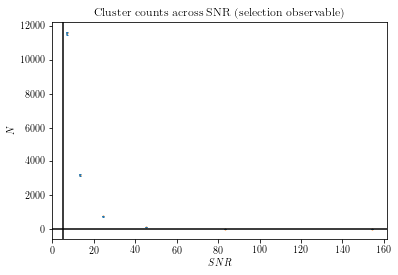

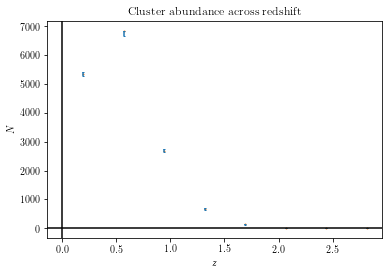

In [9]:
size_marker = 1

pl.errorbar(bins_centres_snr,n_binned_snr_theory,yerr=np.sqrt(n_binned_snr_theory),color="tab:blue",
            linestyle="none",fmt="",capsize=size_marker)
pl.scatter(bins_centres_snr,n_binned_snr_obs,color="tab:orange",s=size_marker)
pl.xlabel("$SNR$")
pl.ylabel("$N$")
pl.axvline(x=5.,color="k")
pl.axhline(y=0.,color="k")
pl.title("Cluster counts across SNR (selection observable)")
pl.show()

pl.errorbar(bins_centres_z,n_binned_z_theory,yerr=np.sqrt(n_binned_z_theory),color="tab:blue",
            linestyle="none",fmt="",capsize=size_marker)
pl.scatter(bins_centres_z,n_binned_z_obs,color="tab:orange",s=size_marker)
pl.xlabel("$z$")
pl.ylabel("$N$")
pl.axvline(x=0.,color="k")
pl.axhline(y=0.,color="k")
pl.title("Cluster abundance across redshift")
pl.show()

Alternatively, if you are only interested in the binned number counts across either the selection observable or redshift, they can be computed directly by setting "binned_lik_type" to either "obs_select" or "z".

## Cluster catalogue

The cluster catalogue quantities can be accessed the following way:

In [10]:
catalogue = number_counts.catalogue

q_obs = catalogue.catalogue["q_so_sim"] #tSZ signal-to-noise
p_obs = catalogue.catalogue["p_so_sim"] #CMB lensing signal-to-noise
z = catalogue.catalogue["z"] #Redshift

## Stacked observable

cosmocnc can compute the expected value of any of the stacked observables and its (co)variance. In our SO-like catalogue, this is the stacked CMB lensing signal-to-noise. This can be done as follows:

In [11]:
cnc_params["likelihood_type"] = "unbinned"
cnc_params["observables"] = [["q_so_sim"]] #There is only one cluster-by-cluster mass observable.
cnc_params["data_lik_from_abundance"] = False #So that the backward convolutional approach is followed (necessary for the stacked likelihood)
cnc_params["stacked_likelihood"] = True
cnc_params["stacked_data"] = ["p_so_sim_stacked"] #List of stacked data
cnc_params["compute_stacked_cov"] = True

number_counts.cnc_params = cnc_params

number_counts.initialise()
log_lik = number_counts.get_log_lik() #We compute the unbinned + stacked likelihood

Time 8.368499517440796
log_lik 98412.8630007719


We now retrieve the results:

In [12]:
p_stacked_obs = number_counts.catalogue.stacked_data["p_so_sim_stacked"]["data_vec"]
p_stacked_theory = number_counts.stacked_model["p_so_sim_stacked"]
p_stacked_std = np.sqrt(number_counts.stacked_variance["p_so_sim_stacked"])

print("Predicted stacked observable =",p_stacked_theory,"+-",p_stacked_std)
print("Observed stacked observable =",p_stacked_obs)

Predicted stacked observable = 0.3082524841255903 +- 0.008013697024074675
Observed stacked observable = 0.3109265614902756


Note that, in this case, we can also easily compute the observed value of the stacked observable from the catalogue itself:

In [13]:
p_stacked_obs_2 = np.mean(p_obs)
print("Observed stacked observable =",p_stacked_obs_2)

Observed stacked observable = 0.3109265614902756


## Likelihood evaluation

Let us now evaluate and plot the unbinned likelihood for the SZ signal-to-noise as a function of $\sigma_8$.

In [14]:
cnc_params["likelihood_type"] = "unbinned"
cnc_params["observables"] = [["q_so_sim"]] #There is only one cluster-by-cluster mass observable.
cnc_params["data_lik_from_abundance"] = True #So that the forward convolutional approach is followed (faster).
cnc_params["stacked_likelihood"] = False

number_counts.cnc_params = cnc_params
number_counts.initialise()

n = 20
sigma_8_vec = np.linspace(0.808,0.815,n)
log_lik = np.zeros(n)


for i in range(0,n):
    
    cosmo_params["sigma_8"] = sigma_8_vec[i]
    number_counts.update_params(cosmo_params,scal_rel_params)
    log_lik[i] = number_counts.get_log_lik()
  
lik_vec = np.exp(log_lik-np.max(log_lik))

cnc_params["sigma_8"] = 0.811


Total clusters 15170.40690773683
Time 1.554419994354248
log_lik 98392.34874628257
Total clusters 15226.516224117615
Time 1.5709733963012695
log_lik 98394.466984847
Total clusters 15282.775669511424
Time 1.5849661827087402
log_lik 98396.34884576935
Total clusters 15339.18546503943
Time 1.4956543445587158
log_lik 98397.99426588803
Total clusters 15395.745831753255
Time 1.493947982788086
log_lik 98399.40318169714
Total clusters 15452.456990634988
Time 1.5149869918823242
log_lik 98400.57552945867
Total clusters 15509.31916259355
Time 1.5159382820129395
log_lik 98401.51124513522
Total clusters 15566.332568469554
Time 1.47837495803833
log_lik 98402.21026444591
Total clusters 15623.497429029394
Time 1.5612938404083252
log_lik 98402.67252282536
Total clusters 15680.813964967725
Time 1.524674654006958
log_lik 98402.89795544898
Total clusters 15738.28239691034
Time 1.517033576965332
log_lik 98402.88649722839
Total clusters 15795.902945395246
Time 1.502274751663208
log_lik 98402.63808279176
Total

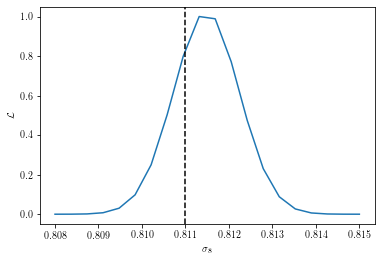

In [15]:
pl.plot(sigma_8_vec,lik_vec)
pl.axvline(x=0.811,linestyle="dashed",color="k")
pl.xlabel("$\sigma_8$")
pl.ylabel("$\mathcal{L}$")
pl.show()

Here, the dashed vertical line is the true value of $\sigma_8$ for our synthetic catalogue.

The same exercise can be done for the other likelihoods with minor modifications to the code. In particular:

 - Binned likelihood: set "likelihood_type" to "binned", and choose binning scheme through "binned_lik_type".
 - Unbinned likelihood with both the SZ and the CMB lensing mass observable: set "observables" to [["q_so_sim"],["p_so_sim"]] (if they belong to different correlation sets, which is the case here), or to [["q_so_sim","p_so_sim"]] (if they belong to the same correlation set).
 - Unbinned likelihood with the CMB lensing stacked observable: set "stacked_likelihood" to True and "data_lik_from_abundance" to False.
 - Extreme value likelihood: set "likelihood_type" to "extreme_value".

## Goodness of fit

We can easily evaluate the modified Cash goodness-of-fit statistic and compare its value with the theoretical prediction. Here we do so at the true model parameters:

In [16]:
number_counts.cnc_params = cnc_params
number_counts.initialise()

C,C_mean,C_std = number_counts.get_c_statistic()

print("Predicted C =",C_mean,"+-",C_std)
print("Observed C =",C)

Predicted C = 27.601973575267717 +- 7.1184905453706655
Observed C = 20.14040373755536


## Cluster mass estimation

Let us now estimate the masses of the clusters in the catalogue. For this we will only use the SZ mass observable (as well as the redshifts).

In [17]:
cnc_params["likelihood_type"] = "unbinned"
cnc_params["observables"] = [["q_so_sim"]]
cnc_params["data_lik_from_abundance"] = False #So that the backward convolutional approach is followed (needed).
cnc_params["get_masses"] = True

number_counts.cnc_params = cnc_params

number_counts.initialise()
number_counts.get_log_lik()
number_counts.get_masses()

Time 7.536606311798096
log_lik 98402.56655606376


In [18]:
ln_mass_est = number_counts.cluster_lnM #ln mass estimates
ln_mass_std = number_counts.cluster_lnM_std #ln mass standard deviation

Since we are using a synthetic catalogue, we also have access to the true cluster mass.

In [19]:
mass_true = number_counts.catalogue.M #true mass

We can now plot the estimated masses against the true masses.

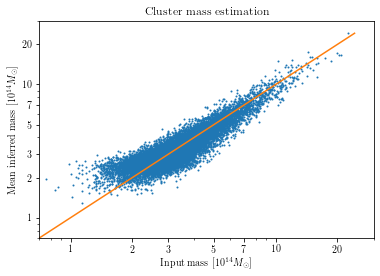

In [20]:
m_x = mass_true
m_y = np.exp(ln_mass_est)

fig = pl.figure()#figsize=(11*cm,8*cm*2))
gs = fig.add_gridspec(1,1)#,hspace=0)
axs = gs.subplots()


axs.scatter(m_x,m_y,s=1)
x = np.linspace(np.min(m_x),np.max(m_y),100)
axs.plot(x,x,color="tab:orange")
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlim([0.7,30.])
axs.set_ylim([0.7,30.])

custom_ticks = [1,2,3,5,7,10,20]

axs.set_xticks(custom_ticks)
axs.set_yticks(custom_ticks)
axs.set_xticklabels(custom_ticks)
axs.set_yticklabels(custom_ticks)
axs.set_ylabel("Mean inferred mass [$10^{14} M_{\odot}$]")
axs.set_xlabel("Input mass [$10^{14} M_{\odot}$]")

axs.set_title("Cluster mass estimation")

pl.show()

## Most extreme cluster

Finally, let's consider the "most extreme cluster", which we define as that with the largest value of the selection observable (SZ signal-to-noise in the SO-like catalogue). 

In [21]:
number_counts.initialise()
number_counts.get_log_lik_extreme_value()
number_counts.eval_extreme_value_quantities()

snr_max_mean = number_counts.obs_select_max_mean
snr_max_std = number_counts.obs_select_max_std
snr_max_obs = np.max(q_obs)

print("Predicted maximum SNR",snr_max_mean,"+-",snr_max_std)
print("Observed maximum SNR",snr_max_obs)

Predicted maximum SNR 115.56243681667802 +- 24.602890727346676
Observed maximum SNR 123.7203444123371
